Version 8 bit for BT

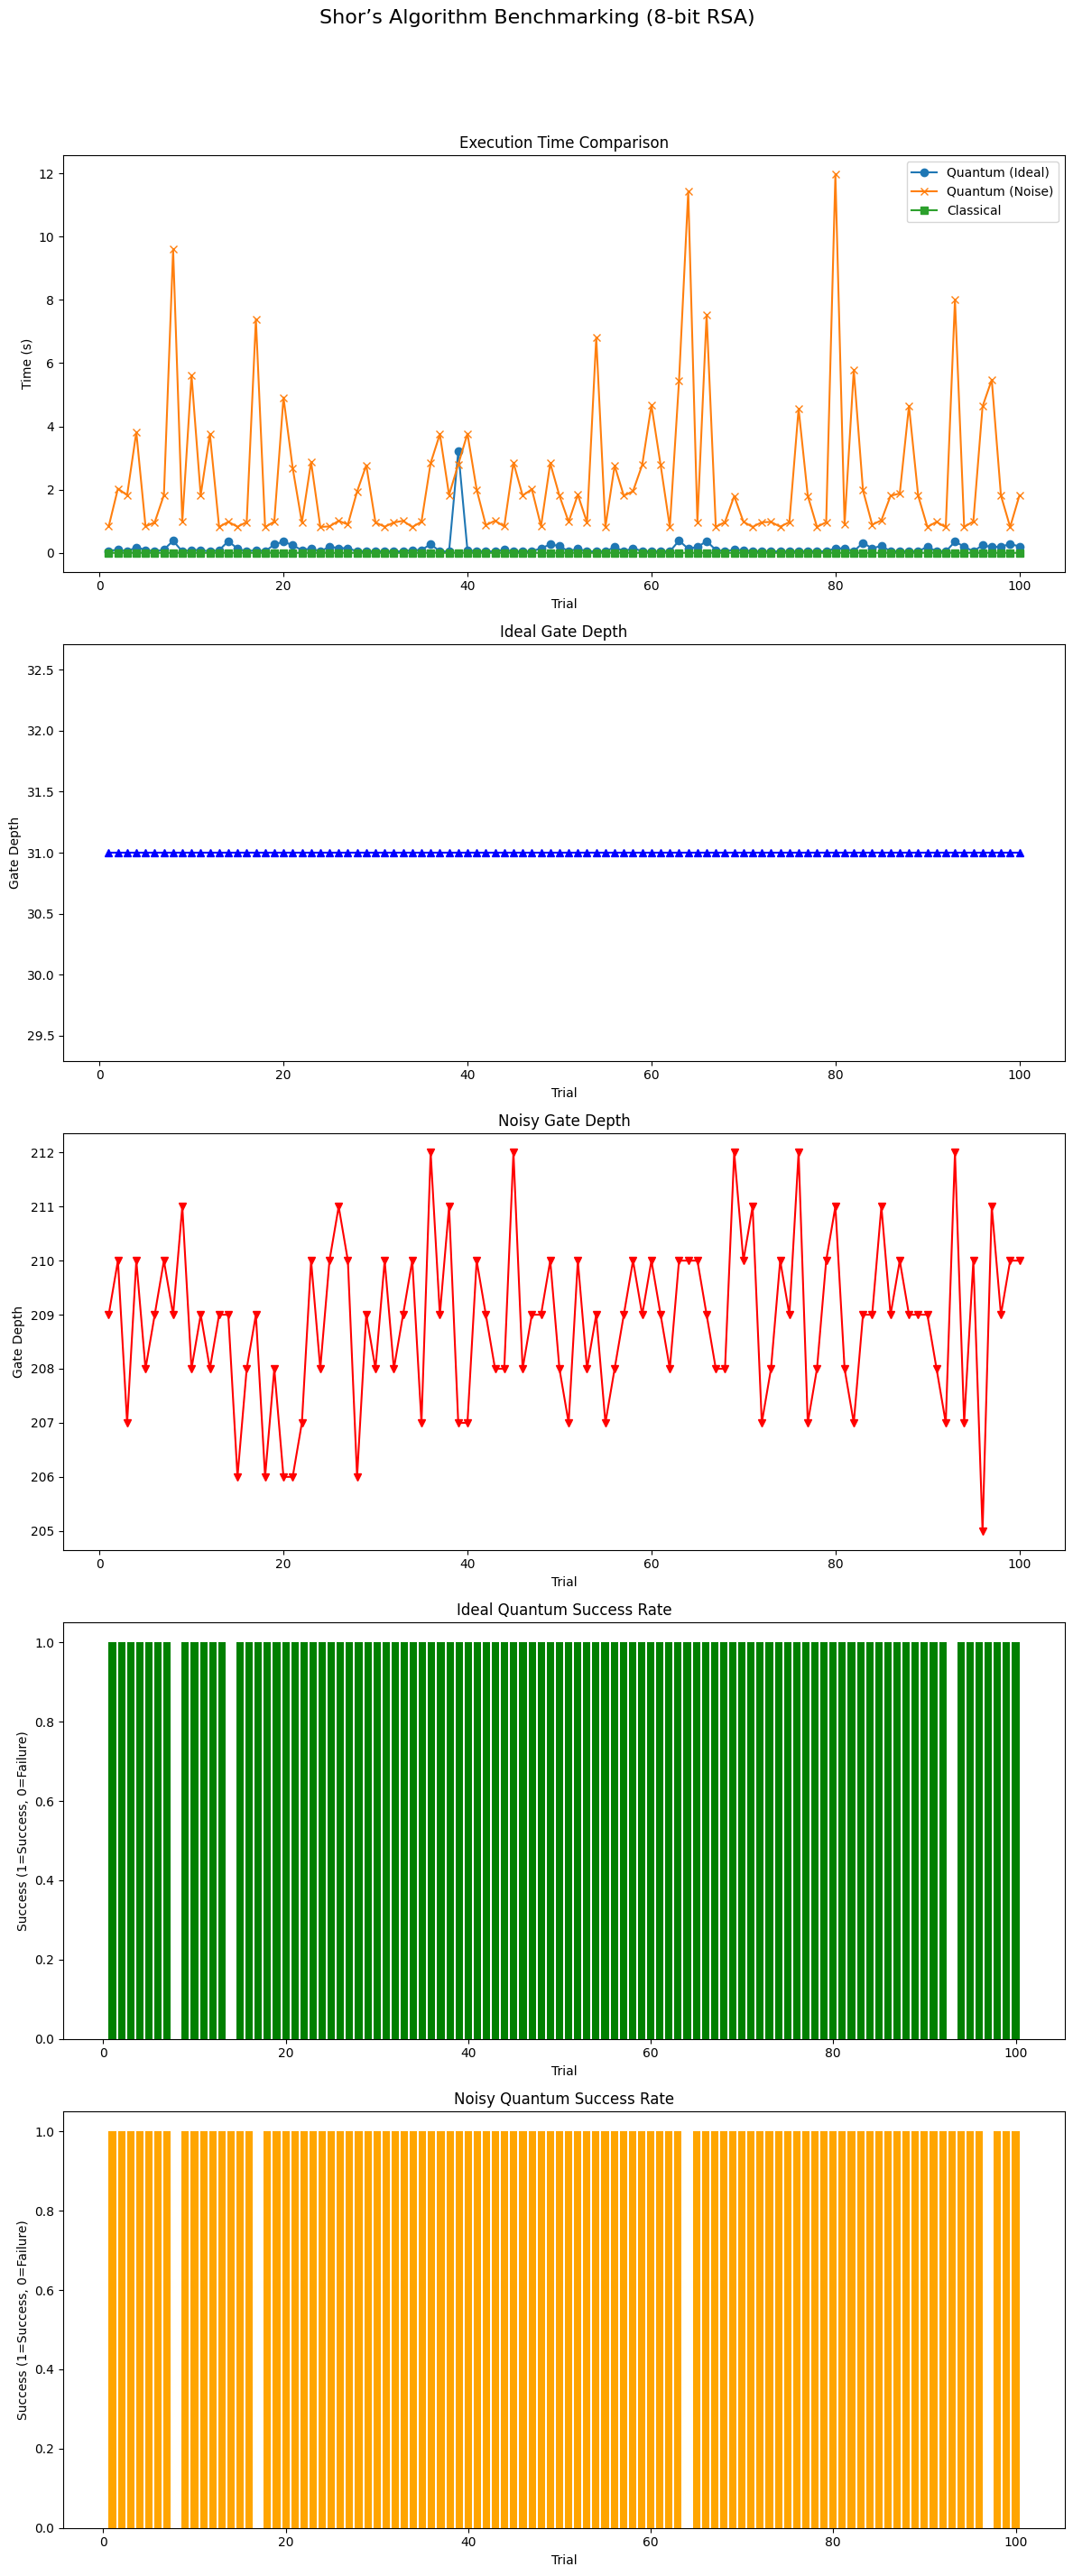


Average Quantum (Ideal) execution time: 0.1470 s
Average Quantum (Noise) execution time: 2.3514 s
Average Classical execution time: 0.0000 s
Average Gate Depth (Ideal): 31.00
Average Gate Depth (Noise): 208.88
Average Qubit Count (Ideal): 10.00
Average Qubit Count (Noise): 10.00
Quantum Success Rate (Ideal): 97.00%
Quantum Success Rate (Noise): 96.00%
Avg Attempts Until Success (Ideal): 3.12 ± 2.52
Avg Attempts Until Success (Noise): 3.35 ± 2.64


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.circuit.library import QFT
from numpy.random import randint
from math import gcd
from fractions import Fraction
import sympy
from sympy import primerange
import random

# Initialize IBM Quantum Service and load a noise model
service = QiskitRuntimeService(channel="ibm_quantum")
backend_real = service.backend("ibm_brisbane")
noise_model_real = NoiseModel.from_backend(backend_real)

bit_size = 8
num_trials = 100
results = []

simulator_noisy = AerSimulator(noise_model=noise_model_real)
simulator_ideal = AerSimulator()

# RSA generation (8-bit)
def generate_8bit_rsa():
    primes = list(primerange(2, 127))
    while True:
        p, q = random.sample(primes, 2)
        n = p * q
        if 128 <= n <= 255:
            return n, p, q

# Modular exponentiation circuit (simplified version)
def modular_exponentiation_circuit(a, N, n_qubits):
    qc = QuantumCircuit(n_qubits + 1)
    for i in range(n_qubits):
        angle = 2 * np.pi * ((a ** (2 ** i)) % N) / N
        qc.cp(angle, i, n_qubits)
    return qc

# QPE + Shor wrapper: prepares control qubits, initializes target to |1>, applies the QFT inverse, and measures.
def qpe_mod_exp(a, N, n_qubits):
    qc = QuantumCircuit(n_qubits + 1, n_qubits)
    qc.h(range(n_qubits))
    qc.x(n_qubits)
    qc.append(modular_exponentiation_circuit(a, N, n_qubits), range(n_qubits + 1))
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

# Shor's algorithm routine (max_attempts=10)
def shors_algorithm(N, simulator, max_attempts=10):
    last_depth = None
    last_qubit_count = None
    for attempt in range(1, max_attempts + 1):
        a = randint(2, N)
        if gcd(a, N) != 1:
            continue

        n_qubits = int(np.ceil(np.log2(N))) + 2
        last_qubit_count = n_qubits
        qc = qpe_mod_exp(a, N, n_qubits)
        compiled_circuit = transpile(qc, simulator, optimization_level=3)
        last_depth = compiled_circuit.depth()

        try:
            result = simulator.run(compiled_circuit, shots=2048).result()
            counts = result.get_counts()
            if not counts:
                continue

            sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:3]
            for measured_value, _ in sorted_counts:
                decimal_value = int(measured_value, 2)
                frac = Fraction(decimal_value, 2 ** n_qubits).limit_denominator(N)
                r = frac.denominator

                if r % 2 == 0 and r > 0:
                    try:
                        plus = gcd(pow(a, r // 2) + 1, N)
                        minus = gcd(pow(a, r // 2) - 1, N)
                        if 1 < plus < N and N % plus == 0:
                            return plus, N // plus, last_depth, True, last_qubit_count, attempt
                        elif 1 < minus < N and N % minus == 0:
                            return minus, N // minus, last_depth, True, last_qubit_count, attempt
                    except Exception:
                        continue
        except Exception:
            continue
    return None, None, last_depth, False, last_qubit_count, max_attempts

# Trial loop
for trial in range(num_trials):
    N, p, q = generate_8bit_rsa()

    # Ideal simulation
    start_time_no_noise = time.time()
    _, _, gate_depth_no_noise, success_no_noise, qubits_no_noise, attempts_no_noise = shors_algorithm(N, simulator_ideal)
    exec_time_no_noise = time.time() - start_time_no_noise

    # Noisy simulation
    start_time_noise = time.time()
    _, _, gate_depth_noise, success_noise, qubits_noise, attempts_noise = shors_algorithm(N, simulator_noisy)
    exec_time_noise = time.time() - start_time_noise

    # Classical baseline
    start_time_classical = time.time()
    sympy.factorint(N)
    exec_time_classical = time.time() - start_time_classical

    results.append({
        "Trial": trial + 1,
        "N": N,
        "Quantum Time (No Noise)": exec_time_no_noise,
        "Quantum Success (No Noise)": int(success_no_noise),
        "Gate Depth (No Noise)": gate_depth_no_noise,
        "Qubit Count (No Noise)": qubits_no_noise,
        "Attempts (No Noise)": attempts_no_noise,
        "Quantum Time (Noise)": exec_time_noise,
        "Quantum Success (Noise)": int(success_noise),
        "Gate Depth (Noise)": gate_depth_noise,
        "Qubit Count (Noise)": qubits_noise,
        "Attempts (Noise)": attempts_noise,
        "Classical Time": exec_time_classical,
    })

# Create DataFrame and save results.
df = pd.DataFrame(results)
df.to_csv("shors_algorithm_results_8bit.csv", index=False)

# Plotting: Create 5 subplots arranged vertically.
fig, axs = plt.subplots(5, 1, figsize=(12, 30))
fig.suptitle(f"Shor’s Algorithm Benchmarking ({bit_size}-bit RSA)", fontsize=16)

# Graph 1: Execution Time Comparison (ideal, noisy, and classical)
axs[0].plot(df["Trial"], df["Quantum Time (No Noise)"], marker="o", label='Quantum (Ideal)')
axs[0].plot(df["Trial"], df["Quantum Time (Noise)"], marker="x", label='Quantum (Noise)')
axs[0].plot(df["Trial"], df["Classical Time"], marker="s", label='Classical')
axs[0].set_title("Execution Time Comparison")
axs[0].set_xlabel("Trial")
axs[0].set_ylabel("Time (s)")
axs[0].legend()

# Graph 2: Ideal Gate Depth
axs[1].plot(df["Trial"], df["Gate Depth (No Noise)"], marker="^", color="blue")
axs[1].set_title("Ideal Gate Depth")
axs[1].set_xlabel("Trial")
axs[1].set_ylabel("Gate Depth")

# Graph 3: Noisy Gate Depth
axs[2].plot(df["Trial"], df["Gate Depth (Noise)"], marker="v", color="red")
axs[2].set_title("Noisy Gate Depth")
axs[2].set_xlabel("Trial")
axs[2].set_ylabel("Gate Depth")

# Graph 4: Ideal Quantum Success Rate (as binary: 1 = success, 0 = failure)
axs[3].bar(df["Trial"], df["Quantum Success (No Noise)"], color="green")
axs[3].set_title("Ideal Quantum Success Rate")
axs[3].set_xlabel("Trial")
axs[3].set_ylabel("Success (1=Success, 0=Failure)")

# Graph 5: Noisy Quantum Success Rate
axs[4].bar(df["Trial"], df["Quantum Success (Noise)"], color="orange")
axs[4].set_title("Noisy Quantum Success Rate")
axs[4].set_xlabel("Trial")
axs[4].set_ylabel("Success (1=Success, 0=Failure)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("shors_algorithm_results_8bit_.png")
plt.show()

# Summary
print(f"\n{'='*40}")
print(f"Average Quantum (Ideal) execution time: {df['Quantum Time (No Noise)'].mean():.4f} s")
print(f"Average Quantum (Noise) execution time: {df['Quantum Time (Noise)'].mean():.4f} s")
print(f"Average Classical execution time: {df['Classical Time'].mean():.4f} s")
print(f"Average Gate Depth (Ideal): {df['Gate Depth (No Noise)'].dropna().mean():.2f}")
print(f"Average Gate Depth (Noise): {df['Gate Depth (Noise)'].dropna().mean():.2f}")
print(f"Average Qubit Count (Ideal): {df['Qubit Count (No Noise)'].dropna().mean():.2f}")
print(f"Average Qubit Count (Noise): {df['Qubit Count (Noise)'].dropna().mean():.2f}")
print(f"Quantum Success Rate (Ideal): {df['Quantum Success (No Noise)'].mean() * 100:.2f}%")
print(f"Quantum Success Rate (Noise): {df['Quantum Success (Noise)'].mean() * 100:.2f}%")
print(f"Avg Attempts Until Success (Ideal): {df['Attempts (No Noise)'].mean():.2f} ± {df['Attempts (No Noise)'].std():.2f}")
print(f"Avg Attempts Until Success (Noise): {df['Attempts (Noise)'].mean():.2f} ± {df['Attempts (Noise)'].std():.2f}")
print(f"{'='*40}")


Version 16 bit


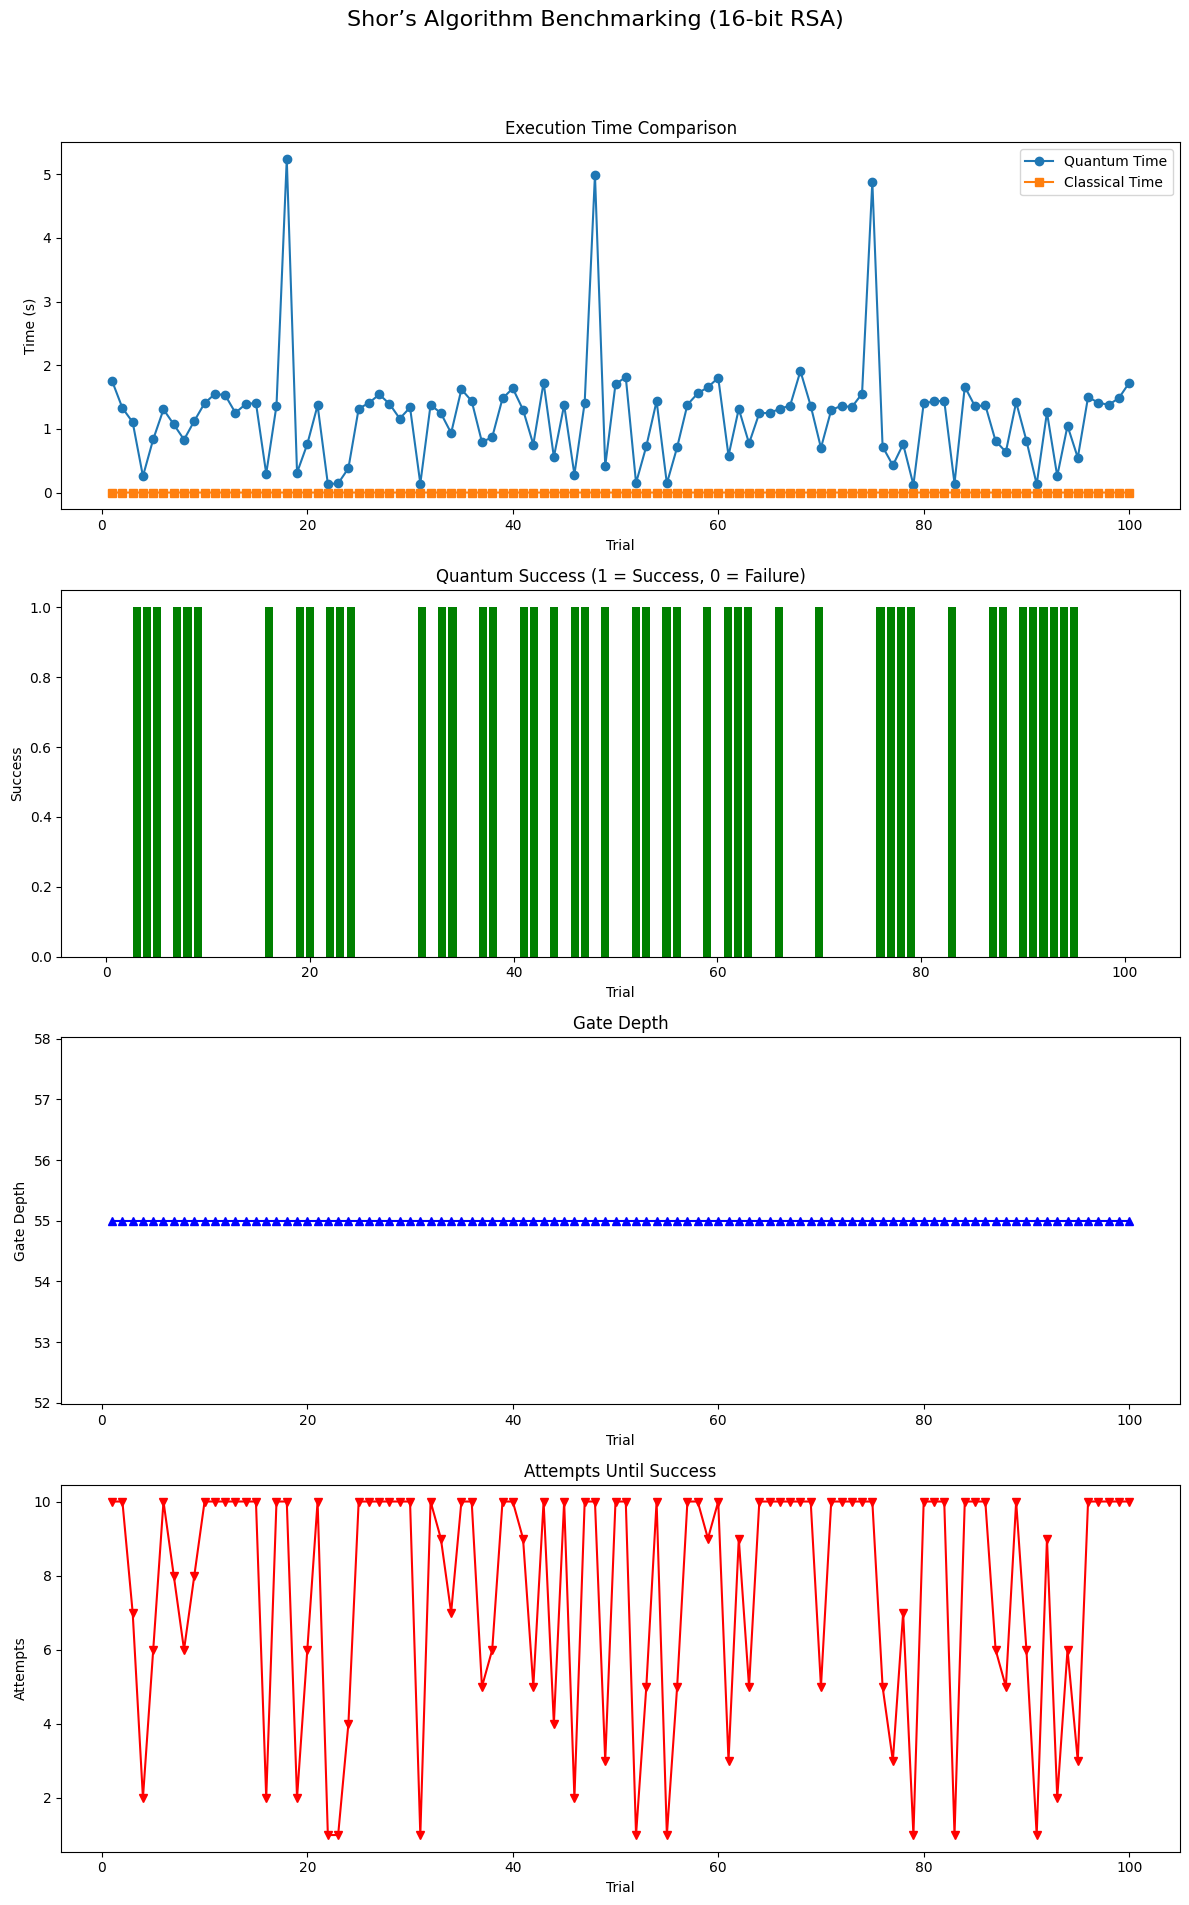


Average Quantum execution time: 1.2123 s
Average Classical execution time: 0.0000 s
Average Gate Depth: 55.00
Average Qubit Count: 18.00
Quantum Success Rate: 46.00%
Avg Attempts Until Success: 7.62 ± 3.21


In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from numpy.random import randint
from math import gcd, ceil, log2
from fractions import Fraction
import sympy
from sympy import primerange
import random

# Settings
bit_size = 16
num_trials = 100
results = []

# Use the ideal simulator (no noise)
simulator_ideal = AerSimulator()

# RSA Generation: Generates a 16-bit RSA modulus N in [2^15, 2^16 - 1]
def generate_16bit_rsa():
    lower = 2**15    # 32768
    upper = 2**16 - 1  # 65535
    # Using primes roughly in [180, 256] tends to yield N in the desired range.
    primes = list(primerange(180, 256))
    while True:
        p, q = random.sample(primes, 2)
        n = p * q
        if lower <= n <= upper:
            return n, p, q

# Modular Exponentiation Circuit (simplified):
def modular_exponentiation_circuit(a, N, n_qubits):
    qc = QuantumCircuit(n_qubits + 1)
    for i in range(n_qubits):
        # Compute the phase angle (in radians) from modular exponentiation.
        angle = 2 * np.pi * ((a ** (2 ** i)) % N) / N
        qc.cp(angle, i, n_qubits)
    return qc

# QPE + Shor Wrapper:
def qpe_mod_exp(a, N, n_qubits):
    qc = QuantumCircuit(n_qubits + 1, n_qubits)
    qc.h(range(n_qubits))             # Put control qubits in superposition.
    qc.x(n_qubits)                    # Prepare the target qubit in |1>
    qc.append(modular_exponentiation_circuit(a, N, n_qubits), range(n_qubits + 1))
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

# Shor's Algorithm Routine (up to max_attempts per trial):
def shors_algorithm(N, simulator, max_attempts=10):
    last_depth = None
    last_qubit_count = None
    for attempt in range(1, max_attempts + 1):
        a = randint(2, N)
        if gcd(a, N) != 1:
            continue

        n_qubits = int(ceil(log2(N))) + 2
        last_qubit_count = n_qubits
        qc = qpe_mod_exp(a, N, n_qubits)
        compiled_circuit = transpile(qc, simulator, optimization_level=3)
        last_depth = compiled_circuit.depth()

        try:
            # Using 2048 shots for a more reliable distribution.
            result = simulator.run(compiled_circuit, shots=2048).result()
            counts = result.get_counts()
            if not counts:
                continue

            sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:3]
            for measured_value, _ in sorted_counts:
                decimal_value = int(measured_value, 2)
                frac = Fraction(decimal_value, 2 ** n_qubits).limit_denominator(N)
                r = frac.denominator

                if r % 2 == 0 and r > 0:
                    try:
                        plus = gcd(pow(a, r // 2) + 1, N)
                        minus = gcd(pow(a, r // 2) - 1, N)
                        if 1 < plus < N and N % plus == 0:
                            return plus, N // plus, last_depth, True, last_qubit_count, attempt
                        elif 1 < minus < N and N % minus == 0:
                            return minus, N // minus, last_depth, True, last_qubit_count, attempt
                    except Exception:
                        continue
        except Exception:
            continue

    return None, None, last_depth, False, last_qubit_count, max_attempts

# Trial loop
for trial in range(num_trials):
    N, p, q = generate_16bit_rsa()

    # Run the ideal (no noise) simulation.
    start_time_quantum = time.time()
    _, _, gate_depth, success, qubit_count, attempts = shors_algorithm(N, simulator_ideal)
    exec_time_quantum = time.time() - start_time_quantum

    # Classical factorization (baseline)
    start_time_classical = time.time()
    _ = sympy.factorint(N)
    exec_time_classical = time.time() - start_time_classical

    results.append({
        "Trial": trial + 1,
        "N": N,
        "Quantum Time": exec_time_quantum,
        "Quantum Success": int(success),
        "Gate Depth": gate_depth,
        "Qubit Count": qubit_count,
        "Attempts": attempts,
        "Classical Time": exec_time_classical,
    })

# Save results to CSV.
df = pd.DataFrame(results)
df.to_csv("shors_algorithm_results_16bit.csv", index=False)

# Plotting: 4 subplots for key metrics.
fig, axs = plt.subplots(4, 1, figsize=(12, 20))
fig.suptitle(f"Shor’s Algorithm Benchmarking ({bit_size}-bit RSA)", fontsize=16)

# 1. Execution Time: Quantum vs. Classical.
axs[0].plot(df["Trial"], df["Quantum Time"], marker="o", label='Quantum Time')
axs[0].plot(df["Trial"], df["Classical Time"], marker="s", label='Classical Time')
axs[0].set_title("Execution Time Comparison")
axs[0].set_xlabel("Trial")
axs[0].set_ylabel("Time (s)")
axs[0].legend()

# 2. Quantum Success: 1 = success, 0 = failure.
axs[1].bar(df["Trial"], df["Quantum Success"], color="green")
axs[1].set_title("Quantum Success (1 = Success, 0 = Failure)")
axs[1].set_xlabel("Trial")
axs[1].set_ylabel("Success")

# 3. Gate Depth.
axs[2].plot(df["Trial"], df["Gate Depth"], marker="^", color="blue")
axs[2].set_title("Gate Depth")
axs[2].set_xlabel("Trial")
axs[2].set_ylabel("Gate Depth")

# 4. Attempts Until Success.
axs[3].plot(df["Trial"], df["Attempts"], marker="v", color="red")
axs[3].set_title("Attempts Until Success")
axs[3].set_xlabel("Trial")
axs[3].set_ylabel("Attempts")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("shors_algorithm_results_16bit.png")
plt.show()

# Summary output.
print(f"\n{'='*40}")
print(f"Average Quantum execution time: {df['Quantum Time'].mean():.4f} s")
print(f"Average Classical execution time: {df['Classical Time'].mean():.4f} s")
print(f"Average Gate Depth: {df['Gate Depth'].dropna().mean():.2f}")
print(f"Average Qubit Count: {df['Qubit Count'].dropna().mean():.2f}")
print(f"Quantum Success Rate: {df['Quantum Success'].mean() * 100:.2f}%")
print(f"Avg Attempts Until Success: {df['Attempts'].mean():.2f} ± {df['Attempts'].std():.2f}")
print(f"{'='*40}")
